In [56]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import json

- określać która dana jest typu bool czyli key, author_code
- obsłużyć 'autor_code', "release_date", 'genres'

In [57]:
TIME_LIMIT = 3600000

In [58]:
def jsonl2df(path):
    with open(path) as fh:
        lines = fh.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']


    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

artists = jsonl2df("datav2/artists.jsonl")
tracks = jsonl2df("datav2/tracks.jsonl")

In [59]:
# result = ['ranking', 'list', ...]

# tracks[tracks['id'].isin(result)]

In [60]:
# Join tracks with artists
prepared_data = pd.merge(tracks,artists, left_on="id_artist", right_on="id")

# Remove rows with empty values
prepared_data = prepared_data.dropna()
prepared_data = prepared_data.drop(columns=["name_x", "popularity", "id_y", "name_y"])

# Convert dates to number of days from earliest track
prepared_data["release_date"] = pd.to_datetime(prepared_data["release_date"], format = "mixed")
min_date = prepared_data['release_date'].min()
prepared_data['release_date'] = (prepared_data['release_date'] - min_date).dt.days

# Scale the attributes to [0, 1]
without = ['id_x', 'duration_ms', 'id_artist', 'genres']
scaled_columns = list(set(prepared_data.columns).difference(without))
prepared_data[scaled_columns] = MinMaxScaler().fit_transform(prepared_data[scaled_columns])

# One-hot encoding of genres
genres_en = pd.get_dummies(prepared_data['genres'].apply(pd.Series).stack()).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, genres_en], axis=1)

# One-hot encoding of artists
artists_en = pd.get_dummies(prepared_data['id_artist']).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, artists_en], axis=1)

prepared_data = prepared_data.drop(columns=['id_artist', 'genres'])

TODO
- Selekcja atrybutów
- Może ograniczyć gatunki i autorów sprawdzając czy występują minimalna liczbę razy, [Infrequent categories sklearn](https://scikit-learn.org/stable/modules/preprocessing.html#infrequent-categories)

In [61]:
# def check_less(data, min_duration=TIME_LIMIT):
#     result = []
#     for group in data['group'].unique():
#         group_data = data[data['group'] == group]
#         if group_data['duration_ms'].sum() < min_duration:
#             result.append(group)
#     return result

In [62]:
# def merge_clusters(data, min_duration=TIME_LIMIT):
#     params = data.drop(columns=['duration_ms', 'id_x'])
#     clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(params)
#     # clustering = AgglomerativeClustering(n_clusters=10).fit(params)
#     data.loc[:, 'group'] = clustering.labels_

#     n_samples = data.shape[0]
#     cluster_map = {i: i for i in range(n_samples)}  # Mapa dla połączeń klastrów

#     for i in range(clustering.children_.shape[0]):
#         cluster_1 = int(clustering.children_[i, 0])
#         cluster_2 = int(clustering.children_[i, 1])

#         mapped_cluster_1 = cluster_map.get(cluster_1, cluster_1)
#         mapped_cluster_2 = cluster_map.get(cluster_2, cluster_2)

#         sum_duration_1 = data.loc[data['group'] == mapped_cluster_1, 'duration_ms'].sum()
#         sum_duration_2 = data.loc[data['group'] == mapped_cluster_2, 'duration_ms'].sum()

#         if sum_duration_1 < min_duration or sum_duration_2 < min_duration:
#             new_cluster = max(cluster_map.values()) + 1
#             cluster_map[cluster_1] = new_cluster
#             cluster_map[cluster_2] = new_cluster
#             data.loc[data['group'] == mapped_cluster_1, 'group'] = new_cluster
#             data.loc[data['group'] == mapped_cluster_2, 'group'] = new_cluster
#             cluster_map[mapped_cluster_1] = new_cluster
#             cluster_map[mapped_cluster_2] = new_cluster

#     return data

In [63]:
def check_all_more_than_hour(data: pd.DataFrame):
    return all(data.groupby(by=['group'])['duration_ms'].sum() > TIME_LIMIT)

In [64]:
def my_merge_clusters(data, min_duration=TIME_LIMIT):
    params = data.drop(columns=['duration_ms', 'id_x'])
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(params)
    # clustering = AgglomerativeClustering(n_clusters=3).fit(params)

    data.loc[:, 'group'] = clustering.labels_

    n_samples = data.shape[0]

    # sprawdzać też czy nie przekroczy dystansu
    for i, (cluster1, cluster2) in enumerate(clustering.children_): # children zawiera listę krotek które klastry się łączą
        data.loc[data['group'] == cluster1, 'group'] = n_samples + i
        data.loc[data['group'] == cluster2, 'group'] = n_samples + i
        if check_all_more_than_hour(data):
            return data

    return data

In [65]:
# p = my_merge_clusters(prepared_data[:100])

In [66]:
# p

In [67]:
# # Dataframe (id, group)
# def advanced_model(data):
#     result = merge_clusters(data)

#     less_hour = check_less(result)

#     result = data[~data['group'].isin(less_hour)]

#     return result[['id_x', 'group']]

In [68]:
# x = advanced_model(prepared_data[:100])

In [69]:
# p.groupby(by='group').count()

In [70]:
# result = x[x['group'] == 7795]['id_x']
# tracks[tracks['id'].isin(result)].describe()

Zamiast ponownego liczenia klastrów zrobić to na podstawie utworzonych może

In [71]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [72]:
# clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(test)

# plot_dendrogram(clustering, truncate_mode="level", p=3)

In [73]:
from sklearn.decomposition import PCA

def pca_scatter(model, labels):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(model)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title('Aglomerative Clustering with PCA')
    plt.show()

In [81]:
test = prepared_data[:100]

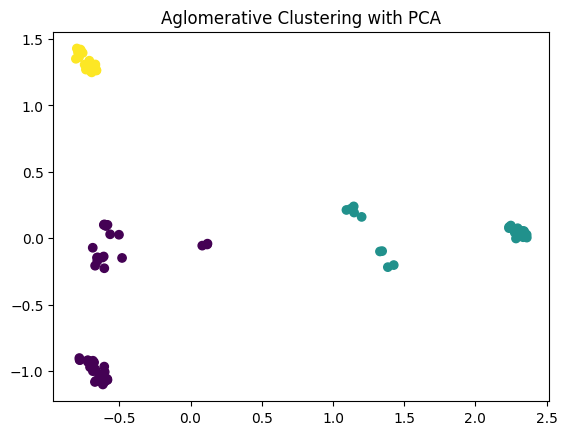

In [83]:
params = test.drop(columns=['id_x', 'duration_ms'])

clustering = AgglomerativeClustering(n_clusters=3).fit(params)
labels = clustering.labels_
pca_scatter(params, labels)

In [84]:
labels

array([0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1])

/tmp/ipykernel_19329/3013538123.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'group'] = clustering.labels_


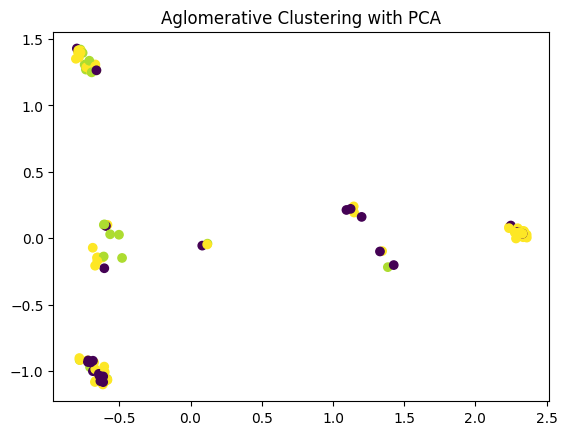

In [85]:
my = my_merge_clusters(test)

dataset = my.drop(columns=['id_x', 'duration_ms', 'group'])
labels = my['group']
pca_scatter(dataset, labels)